In [1]:
import numpy as np
import pandas as pd

### Data Preprcessing

In [2]:
mks = pd.read_csv("data/MKSfull.csv")

In [3]:
#data preprocessing 
#remove NaN values
nans = mks[mks['Close'].isnull()]
mks.drop(nans.index, inplace=True) 

### Create Features Dataframes

In [29]:
# Initialize a data frames to hold the Features and the value
X_len = 7000
days = 15

Χ_columns = []
for j in range(days):
    Χ_columns.append('i+%s' % str(j))
    
Χ_columns.append('Range')
Χ_columns.append('Change')
Χ_columns.append('ChangePercentage')
    
X = pd.DataFrame(index=range(X_len),columns = Χ_columns)
y = pd.DataFrame(index=range(X_len), columns = ['Close'])


for i in range(X_len):
    stock_range = []
    stock_change = []
    stock_change_perc = []
    for j in range(days):
        X.iloc[i]['i+%s' % str(j)] = mks.iloc[i + j]['Close']
        stock_range.append(mks.iloc[i + j]['High'] - mks.iloc[i + j]['Low'])
        stock_change.append(mks.iloc[i + j]['Close'] - mks.iloc[i + j]['Open'])
        stock_change_perc.append(((mks.iloc[i + j]['Close'] - mks.iloc[i + j]['Open']) / mks.iloc[i + j]['Open'])* 100) 
    X.iloc[i]['Range'] = np.mean(stock_range)
    X.iloc[i]['Change'] = np.mean(stock_change)
    X.iloc[i]['ChangePercentage'] = np.mean(stock_change_perc)
    y.iloc[i] = mks.iloc[(i + j + 1)]['Close']
    
v = pd.concat([X, y], axis=1)
v.head()

,i+0,i+1,i+2,i+3,i+4,i+5,i+6,i+7,i+8,i+9,i+10,i+11,i+12,i+13,i+14,Range,Change,ChangePercentage,Close
0,249.86,254.221,265.437,260.452,261.699,261.699,262.945,260.452,256.714,251.729,245.498,245.498,251.729,246.745,245.498,0,0,0,241.759
1,254.221,265.437,260.452,261.699,261.699,262.945,260.452,256.714,251.729,245.498,245.498,251.729,246.745,245.498,241.759,0,0,0,239.267
2,265.437,260.452,261.699,261.699,262.945,260.452,256.714,251.729,245.498,245.498,251.729,246.745,245.498,241.759,239.267,0,0,0,238.021
3,260.452,261.699,261.699,262.945,260.452,256.714,251.729,245.498,245.498,251.729,246.745,245.498,241.759,239.267,238.021,0,0,0,236.775
4,261.699,261.699,262.945,260.452,256.714,251.729,245.498,245.498,251.729,246.745,245.498,241.759,239.267,238.021,236.775,0,0,0,241.759


In [30]:
v.tail()

,i+0,i+1,i+2,i+3,i+4,i+5,i+6,i+7,i+8,i+9,i+10,i+11,i+12,i+13,i+14,Range,Change,ChangePercentage,Close
6995,335.2,335.5,338.7,339.3,338.8,337.8,330.5,330.4,334.2,329.3,327.9,330.1,324.9,337.3,331.9,6.27768,0.166665,0.000600155,334.6
6996,335.5,338.7,339.3,338.8,337.8,330.5,330.4,334.2,329.3,327.9,330.1,324.9,337.3,331.9,334.6,6.48661,0.126664,0.000479271,332.3
6997,338.7,339.3,338.8,337.8,330.5,330.4,334.2,329.3,327.9,330.1,324.9,337.3,331.9,334.6,332.3,6.47994,-0.0733357,-0.000117708,335.5
6998,339.3,338.8,337.8,330.5,330.4,334.2,329.3,327.9,330.1,324.9,337.3,331.9,334.6,332.3,335.5,6.41394,-0.100002,-0.000191183,331.4
6999,338.8,337.8,330.5,330.4,334.2,329.3,327.9,330.1,324.9,337.3,331.9,334.6,332.3,335.5,331.4,6.75394,-0.180001,-0.00042976,337


### Calculate squared daily deviation 

In [31]:
#Calculate squared daily deviation
dv = pd.DataFrame(index=range(X_len), columns = ['dv'])
dv.iloc[0] = 0
for i in range(1, X_len):
    dv.iloc[i] = mks.iloc[i]['Close'] - mks.iloc[i - 1]['Close']    
dv = np.sqrt((dv ** 2).mean())
dv

dv    7.558524
dtype: float64

### Split train/test set

In [32]:
def split_train_test_set(X, y, test_size=0.2):  
    if len(X) != len(y):
        return "Error"
    split_index = int(len(X) * (1-test_size))
    X_train = X[:split_index]
    X_test = X[split_index:]
    y_train = y[:split_index]
    y_test = y[split_index:]
    return X_train, X_test, y_train, y_test

### Create cross validation folds

In [33]:
def create_cv_sets(n_splits, size):
    cv_sets = []
    for index in range(n_splits):
        X_train, X_test, y_train, y_test = split_train_test_set(X[index:index + size], y[index:index + size])    
        cv_sets.append([X_train, X_test, y_train, y_test])
    return cv_sets 

### Define metrics and print metrics

In [34]:
# Import metrics, Crete custom metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error

def rmsp(test, pred):
    return np.sqrt(np.mean(((test - pred)/test)**2)) * 100

def rmse(test, pred):
    return np.sqrt(((test - pred) ** 2).mean())

def print_metrics(test, pred):
    print('RMSE %f'%  rmse(test, pred))
    print('Root Mean Squared Percentage Error %f'% rmsp(test, pred))
    print('Mean Absolute Error: %f'% mean_absolute_error(test, pred))
    print('Explained Variance Score: %f'% explained_variance_score(test, pred))
    print('Mean Squared Error: %f'% mean_squared_error(test, pred))
    print('R2 score: %f'% r2_score(test, pred))
    print('')

In [35]:
n_splits = 7
size =1000

cv_sets = create_cv_sets(n_splits, size)

### Benchmark model 

In [36]:
def model_persistence(x):
    return x

def set_prediction(test_X):
    predictions = list()
    for x in test_X['i+%s' % str(days-1)]:
        yhat = model_persistence(x)
        predictions.append(yhat)
    return predictions

#Iterate through cv_sets, calc errors, print metrics
benchmark_errs=[]
for X_train, X_test, y_train, y_test in cv_sets:
    pred = set_prediction(X_test)
    benchmark_errs.append(rmse(y_test['Close'], pred))
    print_metrics(y_test['Close'], pred)

RMSE 4.730149
Root Mean Squared Percentage Error 1.053588
Mean Absolute Error: 3.589005
Explained Variance Score: 0.977357
Mean Squared Error: 22.374307
R2 score: 0.977121

RMSE 4.730145
Root Mean Squared Percentage Error 1.052969
Mean Absolute Error: 3.589000
Explained Variance Score: 0.977528
Mean Squared Error: 22.374269
R2 score: 0.977330

RMSE 4.769385
Root Mean Squared Percentage Error 1.059620
Mean Absolute Error: 3.626385
Explained Variance Score: 0.977500
Mean Squared Error: 22.747034
R2 score: 0.977257

RMSE 4.818575
Root Mean Squared Percentage Error 1.066213
Mean Absolute Error: 3.654420
Explained Variance Score: 0.977555
Mean Squared Error: 23.218663
R2 score: 0.977290

RMSE 4.914917
Root Mean Squared Percentage Error 1.081329
Mean Absolute Error: 3.719850
Explained Variance Score: 0.977430
Mean Squared Error: 24.156412
R2 score: 0.977098

RMSE 5.088772
Root Mean Squared Percentage Error 1.106970
Mean Absolute Error: 3.807080
Explained Variance Score: 0.976974
Mean Squared

### Train and Tune Linear Regressor

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn import grid_search
from sklearn.model_selection import GridSearchCV

def get_lr_model(X, y):
    regressor = LinearRegression()
    parameters = {'fit_intercept':[True, False], 'normalize':[True, False], 'copy_X':[True, False]}
    grid = GridSearchCV(regressor, parameters)
    grid.fit(X_train, y_train)
    return grid.best_estimator_

### Iterate through cross validation sets, calc errors, print metrics

In [38]:
#Iterate through cv_sets, calc errors, print metrics
lr_regs = []
lr_errs=[]
for X_train, X_test, y_train, y_test in cv_sets:
    lr_reg = get_lr_model(X_train, y_train)
    lr_regs.append(lr_reg)
    pred = lr_reg.predict(X_test)
    lr_errs.append(rmse(y_test, pred))
    print_metrics(y_test, pred)

RMSE 4.734350
Root Mean Squared Percentage Error 1.054045
Mean Absolute Error: 3.641621
Explained Variance Score: 0.977190
Mean Squared Error: 22.414070
R2 score: 0.977081

RMSE 4.736891
Root Mean Squared Percentage Error 1.054041
Mean Absolute Error: 3.645021
Explained Variance Score: 0.977343
Mean Squared Error: 22.438138
R2 score: 0.977265

RMSE 4.783293
Root Mean Squared Percentage Error 1.061934
Mean Absolute Error: 3.684445
Explained Variance Score: 0.977234
Mean Squared Error: 22.879891
R2 score: 0.977125

RMSE 4.819607
Root Mean Squared Percentage Error 1.065845
Mean Absolute Error: 3.705027
Explained Variance Score: 0.977393
Mean Squared Error: 23.228608
R2 score: 0.977281

RMSE 4.896625
Root Mean Squared Percentage Error 1.077672
Mean Absolute Error: 3.755883
Explained Variance Score: 0.977431
Mean Squared Error: 23.976936
R2 score: 0.977268

RMSE 5.079582
Root Mean Squared Percentage Error 1.104621
Mean Absolute Error: 3.845646
Explained Variance Score: 0.976873
Mean Squared

In [39]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10,5

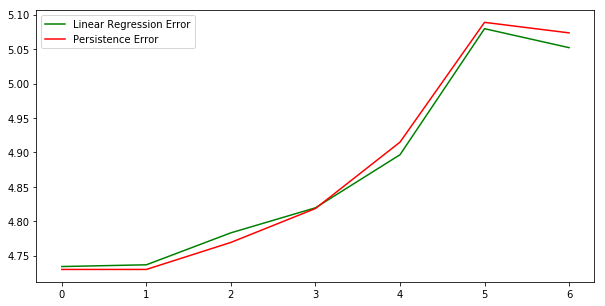

In [40]:
t = range(n_splits)
plt.plot(t, lr_errs, 'g', label='Linear Regression Error')
plt.plot(t, benchmark_errs, 'r', label='Persistence Error')

plt.legend()
plt.show()

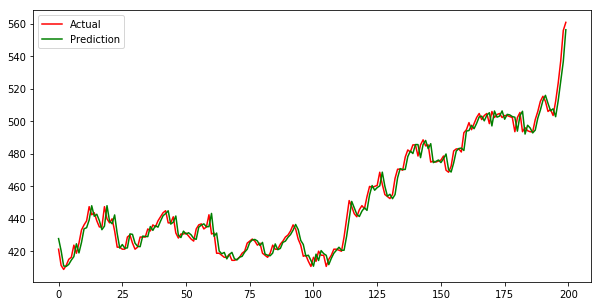

In [41]:
rcParams['figure.figsize'] = 10,5
t = range(len(y_test))
plt.plot(t, y_test, 'r', label='Actual')
plt.plot(t, lr_regs[n_splits - 1].predict(X_test), 'g', label='Prediction')
plt.legend()
plt.show()

In [53]:
lr_regs[0].coef_

array([[ 0.03639832, -0.04564089,  0.05868698, -0.00380463, -0.04778587,
         0.00942654,  0.01784966,  0.03054984, -0.0086529 ,  0.01667777,
        -0.13795505,  0.1788635 , -0.06610162, -0.09220368,  1.05437346,
         0.        ,  0.        ,  0.        ]])

In [43]:
from sklearn.linear_model import Ridge 

def get_ridge_model(X_train, X_test, y_train, y_test):
    r_reg = Ridge()
    r_reg.fit(X_train, y_train)
    return r_reg

In [44]:
#Iterate through cv_sets, calc errors, print metrics
rr_regs=[]
rr_errs=[]
for X_train, X_test, y_train, y_test in cv_sets:
    rr_reg = get_ridge_model(X_train,X_test,y_train,y_test)
    pred = rr_reg.predict(X_test)
    rr_regs.append(rr_reg)
    rr_errs.append(rmse(y_test, pred))
    print_metrics(y_test, pred)    

RMSE 4.793773
Root Mean Squared Percentage Error 1.064788
Mean Absolute Error: 3.702716
Explained Variance Score: 0.977190
Mean Squared Error: 22.980258
R2 score: 0.976502

RMSE 4.792257
Root Mean Squared Percentage Error 1.063939
Mean Absolute Error: 3.700587
Explained Variance Score: 0.977349
Mean Squared Error: 22.965727
R2 score: 0.976731

RMSE 4.850355
Root Mean Squared Percentage Error 1.073975
Mean Absolute Error: 3.750095
Explained Variance Score: 0.977215
Mean Squared Error: 23.525940
R2 score: 0.976479

RMSE 4.889292
Root Mean Squared Percentage Error 1.078004
Mean Absolute Error: 3.769314
Explained Variance Score: 0.977334
Mean Squared Error: 23.905173
R2 score: 0.976619

RMSE 4.979985
Root Mean Squared Percentage Error 1.092184
Mean Absolute Error: 3.829371
Explained Variance Score: 0.977338
Mean Squared Error: 24.800246
R2 score: 0.976488

RMSE 5.171586
Root Mean Squared Percentage Error 1.120326
Mean Absolute Error: 3.917359
Explained Variance Score: 0.976727
Mean Squared

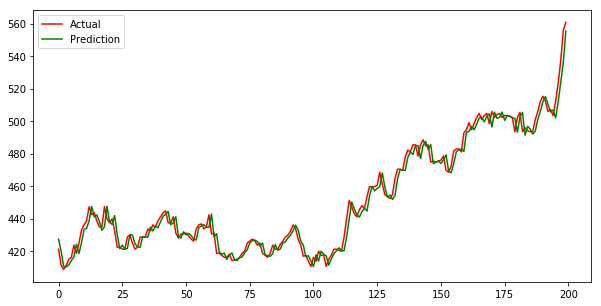

In [45]:
t = range(len(y_test))
plt.plot(t, y_test, 'r', label='Actual')
plt.plot(t, rr_regs[6].predict(X_test), 'g', label='Prediction')
plt.legend()
plt.show()

In [46]:
rr_regs[1].coef_

array([[ 0.03290649, -0.045081  ,  0.0619717 , -0.00540411, -0.04862029,
         0.00848372,  0.01784502,  0.0312394 , -0.00881302,  0.01823023,
        -0.13758844,  0.1766245 , -0.0639728 , -0.09481773,  1.05281446,
         0.        ,  0.        ,  0.        ]])

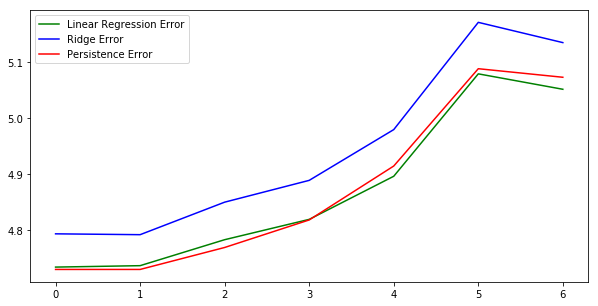

In [47]:
t = range(n_splits)
plt.plot(t, lr_errs, 'g', label='Linear Regression Error')
plt.plot(t, rr_errs, 'b', label='Ridge Error')
plt.plot(t, benchmark_errs, 'r', label='Persistence Error')
plt.legend()
plt.show()

In [48]:
from sklearn.svm import LinearSVR
def lsvr(X_train, X_test, y_train, y_test):
    svr = LinearSVR()
    svr.fit(X_train, y_train.values.ravel())
    return svr

In [49]:
#Iterate through cv_sets, calc errors, print metrics
svrs=[]
svr_errs=[]
for X_train, X_test, y_train, y_test in cv_sets: 
    svr = lsvr(X_train, X_test, y_train, y_test)
    svrs.append(svr)
    pred = svr.predict(X_test)
    svr_errs.append(rmse(y_test.values.ravel(), pred)) 
    print_metrics(y_test.values.ravel(), pred)


RMSE 9.694972
Root Mean Squared Percentage Error 2.174608
Mean Absolute Error: 8.564681
Explained Variance Score: 0.976765
Mean Squared Error: 93.992491
R2 score: 0.903889

RMSE 5.790446
Root Mean Squared Percentage Error 1.277906
Mean Absolute Error: 4.700343
Explained Variance Score: 0.977305
Mean Squared Error: 33.529260
R2 score: 0.966028

RMSE 5.187719
Root Mean Squared Percentage Error 1.161144
Mean Absolute Error: 4.020967
Explained Variance Score: 0.977200
Mean Squared Error: 26.912430
R2 score: 0.973093

RMSE 5.056099
Root Mean Squared Percentage Error 1.127815
Mean Absolute Error: 3.887958
Explained Variance Score: 0.977379
Mean Squared Error: 25.564137
R2 score: 0.974996

RMSE 15.900168
Root Mean Squared Percentage Error 3.547879
Mean Absolute Error: 15.112436
Explained Variance Score: 0.976839
Mean Squared Error: 252.815351
R2 score: 0.760313

RMSE 7.846195
Root Mean Squared Percentage Error 1.753083
Mean Absolute Error: 6.675115
Explained Variance Score: 0.977067
Mean Squa

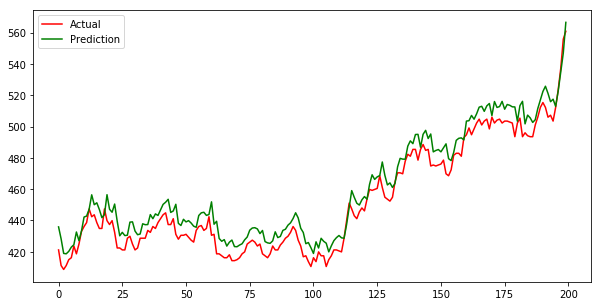

In [50]:
t = range(len(y_test))
plt.plot(t, y_test, 'r', label='Actual')
plt.plot(t, svrs[0].predict(X_test), 'g', label='Prediction')
plt.legend()
plt.show()

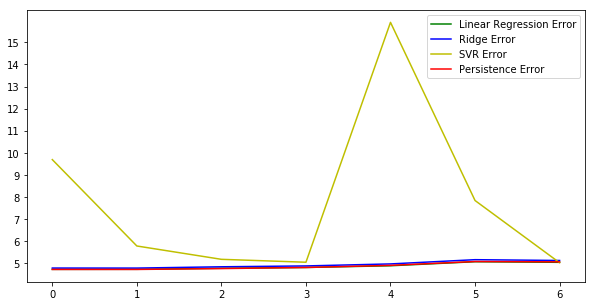

In [51]:
rcParams['figure.figsize'] = 10,5
dvl = [dv]* n_splits
t = range(n_splits)
plt.yticks(np.arange(0, max(svr_errs)))
plt.plot(t, lr_errs, 'g', label='Linear Regression Error')
plt.plot(t, rr_errs, 'b', label='Ridge Error')
plt.plot(t, svr_errs, 'y', label='SVR Error')
plt.plot(t, benchmark_errs, 'r', label='Persistence Error')
plt.legend()
plt.show()

In [52]:
last = np.array([316.200012, 316.299988,314.799988,316.100006,320.5,308.799988,313.700012,310.80,318.30,324.00,301.20, 309.20,307.00,310.20,307.40]).reshape(1,-1)
pred = lr_regs[0].predict(last)
pred


ValueError: shapes (1,15) and (18,1) not aligned: 15 (dim 1) != 18 (dim 0)

In [ ]:
from sklearn.externals import joblib
joblib.dump(lr_regs[0], 'prediction_model_full.pkl') 